# Algoritmos no supervisados 

- KMeans
- Hierchical
- DBSCAN
- Spectral clustering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from sklearn.metrics import silhouette_score, homogeneity_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, completeness_score 
from sklearn.cluster import KMeans

In [3]:
def prepare_kmeans(df,start=1,end=15):
    clusters=[]
    for k in range(start,end):
        kmean = KMeans(n_clusters=k,random_state=42,n_init=20,)
        kmean.fit(df)
        clusters.append(kmean)
    return clusters

In [4]:
def parametrize(df):
    df_new = df.copy()   
    for col in df_new.columns:
        if  col in ['Apr','Carrera','Campus','Sem']:
            continue
        try:
                decimal =1
                cols= pd.to_numeric(df_new[col])
                df_new.loc[cols ==0,col]=0
                df_new.loc[ (cols<=45/decimal) & (cols>0), col]=1
                df_new.loc[ (cols>45/decimal) & (cols <= 55/decimal), col]=2
                df_new.loc[ (cols>55/decimal) & (cols <= 65/decimal), col]=3
                df_new.loc[ cols > 65/decimal, col]=4
        except:
                print(name,col)
    
    return df_new

In [5]:
def parametrize_col(x):
    x[x==0] = 0
    x[x<=45] =1
    x[(x>45) & (x<=55)]=2
    x[(x>5) & (x<=65)]=3
    x[(x>6)]=4
    return x

In [6]:
df = pd.read_csv('../All_Rough_data.csv')
deptos = df.Depto
df.drop(columns=['SM9','SM10','Depto'],inplace=True)

KMeans es susceptible a los datos outliers por lo que para aplicar correctamente este algortimo se deben eliminar los valores outliers

In [7]:
df_kmeans = df.copy()
for i in df.columns:
    if  i in ['Apr','Carrera','Campus','Sem']:
        continue
    q1,q2,q3= df[i].quantile([0.25,0.5,0.75])
    IQR = q3-q1
    lower_cap = q1-1.5*IQR
    upper_cap = q3+1.5*IQR
    df_kmeans[i]= df[i].apply(lambda x:upper_cap if x>(upper_cap) else (lower_cap if x< lower_cap else x ))

In [7]:
clusters= prepare_kmeans(parametrize(df_kmeans).values,1,16)

## Elbow

In [30]:
!pip install yellowbrick

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 KB 9.4 MB/s eta 0:00:00


In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA()
_df = pd.get_dummies(data=parametrize(df),columns=['Campus','Sexo'])
pca.fit(_df)

PCA()

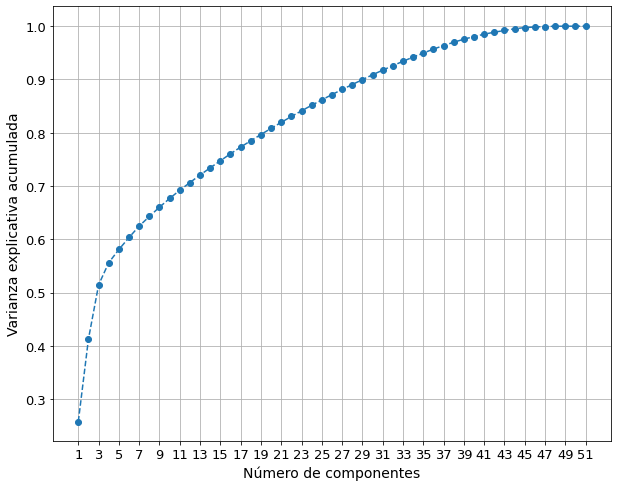

In [172]:
plt.figure(figsize=(10,8))
plt.plot(range(1,_df.shape[1]+1),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.xlabel('Número de componentes',fontdict={'fontsize':14})
plt.tick_params(labelsize=13)
plt.ylabel('Varianza explicativa acumulada',fontdict={'fontsize':14})
plt.xticks(ticks= np.arange(1,_df.shape[1]+1,2))
plt.grid()
plt.savefig('PCAVariance.png')

In [10]:
_df = pd.get_dummies(data=parametrize(df_kmeans),columns=['Campus','Sexo'])
pca = PCA(n_components=19).fit(_df)
scores_pca = pca.transform(_df)

In [208]:
elbow_pca= [KMeans(n_clusters=i,random_state=42).fit(scores_pca).inertia_ for i in range(1,20)]

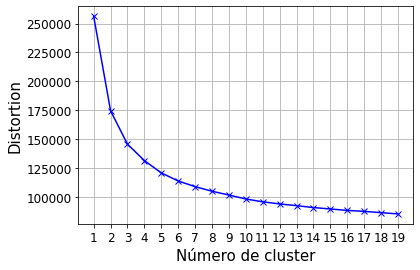

In [209]:
plt.plot(range(1,20,1), elbow_pca, 'bx-')
plt.xlabel('Número de cluster',fontdict={'fontsize':15})
plt.ylabel('Distortion',fontdict={'fontsize':15})
plt.tick_params(labelsize=12)
plt.xticks(ticks=np.arange(1,20,1))
plt.grid()
plt.savefig('ElbowMethod.png',)

In [210]:
models= [KMeans(n_clusters=i,random_state=42).fit_predict(scores_pca) for i in range(1,20)]
sil_scores=[silhouette_score(scores_pca,model) for model in models[1:]]

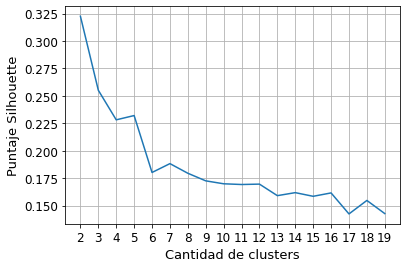

In [211]:
plt.plot(range(2,20), sil_scores )
plt.xticks(ticks=np.arange(2,20,1))
plt.xlabel('Cantidad de clusters',fontdict={'fontsize':13})
plt.ylabel('Puntaje Silhouette',fontdict={'fontsize':13})
plt.tick_params(labelsize=12)
plt.grid()
plt.savefig('Silhouette.png')

In [17]:
km= KMeans(n_clusters=5,random_state=42).fit(scores_pca)
centers= km.cluster_centers_
labels = km.predict(scores_pca)
_df['labels']= labels
df['labels']=labels

In [12]:
silhouette_score(scores_pca,labels)

0.23201452432770378

In [214]:
df_pca = pd.DataFrame(scores_pca)
_df['labels']= labels

In [215]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

_df2=undummify(_df)

In [216]:
df['labels']=_df2['labels']
clusters= _df2.labels.sort_values().unique()

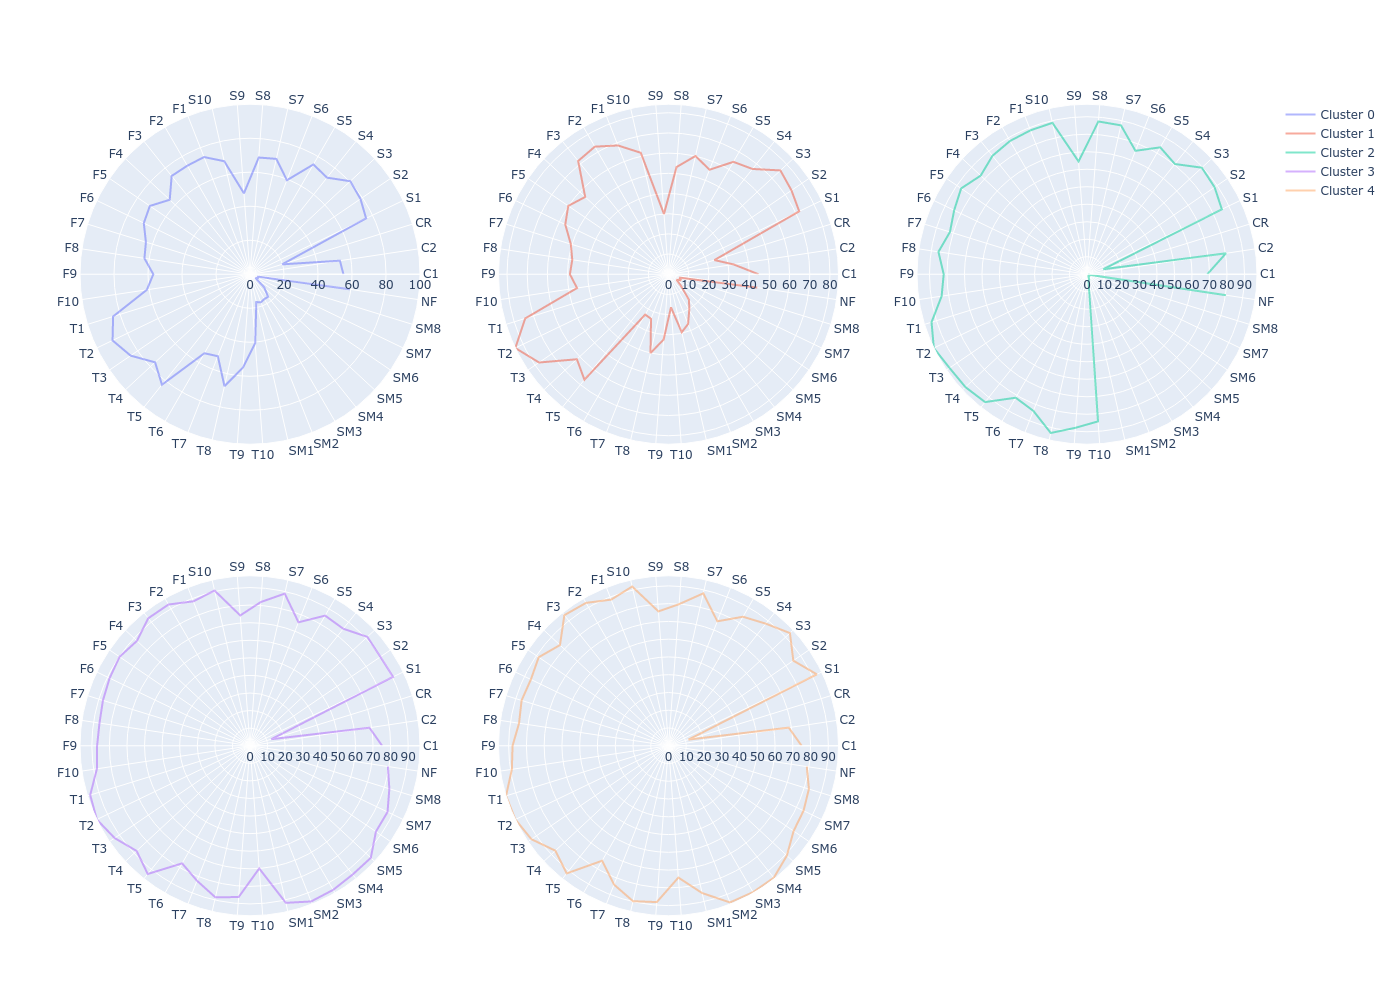

In [221]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

n= 3
db = df.drop(columns=['Carrera','Campus','Sem','Sexo','Apr'])
categories = df.drop(columns=['labels','Carrera','Campus','Sem','Sexo','Apr']).columns
fig = make_subplots(rows=n-1,cols=n,specs=[[{'type': 'polar'}]*n]*(n-1))

for i in range(len(clusters)):
    radio= db[db.labels ==i].drop(columns=['labels']).mean().values
    fig.add_trace(go.Scatterpolar(
          r= [*radio, radio[0]],
          theta=categories,
          #fill='toself',
            opacity=0.5,
          name=f'Cluster {i}'
    ),
        row=(i//n) +1, 
        col= (i%n) +1      )

fig.update_layout(
    autosize=False,
   width=1200,
   height=1000,
    showlegend=True,
    polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 100]
    )),
)

fig.show()
fig.write_image('ClustersKMeans.png',)

In [222]:
((pd.concat(
    [
    pd.crosstab(_df2['labels'],_df2['Sexo'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['Sem'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['Campus'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['Apr'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['NF'],normalize='index').T
    ]
    ,keys=['Sexo','Semestre','Campus', 'Aprobación','Nota'])
))

labels                 0         1         2         3         4
Sexo       0    0.750617  0.765116  0.814935  0.742574  0.682590
           1    0.249383  0.234884  0.185065  0.257426  0.317410
Semestre   1.0  0.718519  0.648837  0.910714  0.415080  0.230361
           2.0  0.281481  0.351163  0.089286  0.584920  0.769639
Campus     0.0  0.567901  0.472093  0.491883  0.453161  0.314225
           1.0  0.427160  0.472093  0.495130  0.439452  0.632696
           2.0  0.004938  0.055814  0.012987  0.107388  0.053079
Aprobación 0    0.353086  0.576744  0.056818  0.092917  0.085987
           1.0  0.646914  0.423256  0.943182  0.907083  0.914013
Nota       1.0  0.283951  0.458140  0.038961  0.063214  0.069002
           2.0  0.069136  0.118605  0.017857  0.029703  0.016985
           3.0  0.153086  0.220930  0.040584  0.028180  0.026539
           4.0  0.493827  0.202326  0.902597  0.878903  0.887473

In [201]:
_df2['Promedio Tareas'] = parametrize_col(df.filter(regex='T').mean(axis=1))
_df2['Promedio Formativos'] = parametrize_col(df.filter(regex='F').mean(axis=1))
_df2['Promedio Actividades'] = parametrize_col(df.filter(regex='SM').mean(axis=1))
_df2['Promedio Tareas'] = parametrize_col(df.filter(regex='T').mean(axis=1))
_df2['Promedio Controles'] = parametrize_col(df.filter(regex='S[0-9]').mean(axis=1))

In [202]:
(pd.concat(
    [
    pd.crosstab(_df2['labels'],_df2['C1'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['C2'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['Promedio Controles'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['Promedio Tareas'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['Promedio Formativos'],normalize='index').T,
    pd.crosstab(_df2['labels'],_df2['Promedio Actividades'],normalize='index').T
    ]
    ,keys=['C1','C2','Controles', 'Tareas','Formativos','Actividades'])
 
)

labels                  0         1         2         3
C1          0.0  0.010679  0.023687  0.015855  0.064695
            1.0  0.139588  0.118435  0.275198  0.436229
            2.0  0.083143  0.072091  0.132503  0.112754
            3.0  0.069413  0.090628  0.103058  0.068392
            4.0  0.697178  0.695160  0.473386  0.317930
C2          0.0  0.115179  0.097837  0.084938  0.384473
            1.0  0.118993  0.127703  0.079275  0.236599
            2.0  0.063310  0.062822  0.056625  0.072089
            3.0  0.082380  0.101957  0.097395  0.072089
            4.0  0.620137  0.609681  0.681767  0.234750
Controles   1.0  0.003051  0.006179  0.014723  0.271719
            2.0  0.013730  0.015448  0.022650  0.147874
            3.0  0.045004  0.039135  0.078143  0.184843
            4.0  0.938215  0.939238  0.884485  0.395564
Tareas      1.0  0.012967  0.012358  0.005663  0.406654
            2.0  0.020595  0.013388  0.026048  0.181146
            3.0  0.042715  0.045314  0.047565  0.166359
            4.0  0.923722  0.928939  0.920725  0.245841
Formativos  1.0  0.011442  0.016478  0.004530  0.526802
            2.0  0.015256  0.017508  0.026048  0.168207
            3.0  0.041190  0.045314  0.063420  0.116451
            4.0  0.932113  0.920700  0.906002  0.188540
Actividades 1.0  0.003051  0.023687  0.997735  0.839187
            2.0  0.022883  0.030896  0.002265  0.077634
            3.0  0.058734  0.065911  0.000000  0.064695
            4.0  0.915332  0.879506  0.000000  0.018484

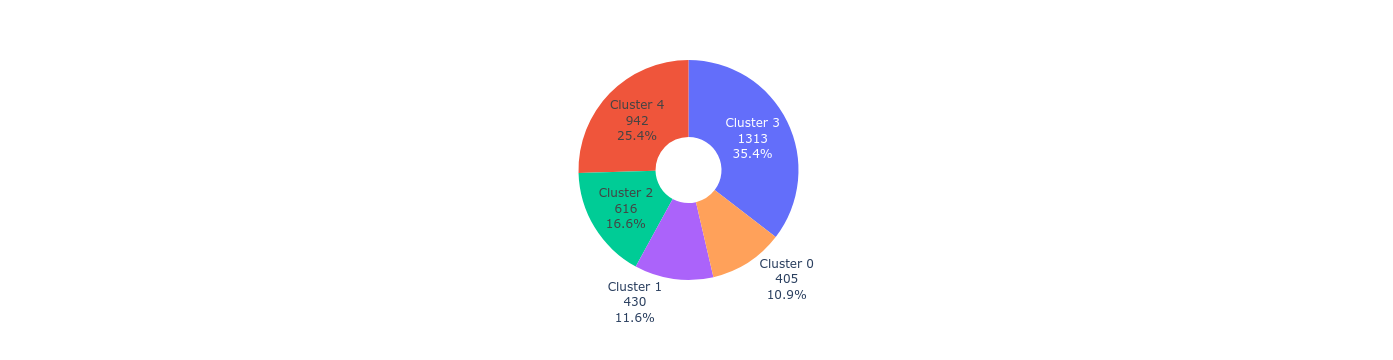

In [18]:
import plotly.express as px
# This dataframe has 244 lines, but 4 distinct values for `day`
df_pie=df.labels.sort_values().value_counts(sort=False).to_frame().reset_index()
df_pie['index']= [f'Cluster {i}' for i in range(len(df_pie))]
fig = px.pie(df_pie, values='labels', names='index',hole=0.3)
fig.update_traces(textposition='auto', textinfo='percent+label+value',showlegend=False)
fig.show()
fig.write_image('KMeansPie.png',scale=.9)

In [19]:
df.to_csv('df_kmeans.csv',index=False)

# Validacion

In [1]:
df=pd.read_csv('df_kmeans.csv')

NameError: name 'pd' is not defined

In [227]:
df_val = pd.read_csv('../2021-02.csv',dtype={'Campus':float,'Sem':float}).iloc[:,1:]
df_val.head()
df_val.drop(columns=['Depto'],inplace=True)
df_val

,C1,C2,CR,S1,S2,S3,S4,S5,S6,S7,...,SM5,SM6,SM7,SM8,NF,Carrera,Campus,Sem,Sexo,Apr
0,84,50,0,100,0,100,40,100,40,100,...,0,100,100,100,66,10,1.0,2.0,0,1
1,43,55,55,100,60,100,0,80,80,100,...,100,100,100,100,70,10,1.0,2.0,1,1
2,73,40,0,100,100,100,100,80,100,100,...,100,100,100,100,64,10,1.0,2.0,0,1
3,100,85,0,100,100,100,100,100,100,100,...,100,100,100,100,95,10,1.0,2.0,0,1
4,90,15,20,100,100,100,80,100,80,100,...,100,100,100,100,70,11,1.0,2.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,0,90,50,0,60,75,80,80,40,100,...,0,0,0,0,49,15,2.0,2.0,0,0
1188,86,30,0,100,100,100,100,0,60,100,...,0,0,0,0,65,15,2.0,2.0,0,1
1189,89,90,0,100,100,100,60,100,100,100,...,100,100,100,0,93,15,2.0,2.0,1,1
1190,86,30,0,100,60,12,60,80,60,80,...,100,100,0,100,60,15,2.0,2.0,0,1


In [228]:
for i in df_val.columns:
    if  i in ['Apr','Carrera','Campus','Sem']:
        continue
    q1,q2,q3= df[i].quantile([0.25,0.5,0.75])
    IQR = q3-q1
    lower_cap = q1-1.5*IQR
    upper_cap = q3+1.5*IQR
    df_kmeans[i]= df_val[i].apply(lambda x:upper_cap if x>(upper_cap) else (lower_cap if x< lower_cap else x ))

In [229]:
_df_val=pd.get_dummies(data=parametrize(df_val),columns=['Campus','Sexo'])

In [230]:
_df_val.fillna(0,inplace=True)

In [231]:
scores_pca2 = pca.transform(_df_val)

In [101]:
labels2 = km.predict(scores_pca2)

In [136]:
silhouette_score(scores_pca,labels)

0.2948525630223889

In [225]:
centroides=NearestCentroid()
centroides.fit(scores_pca,df.labels)

NearestCentroid()

In [233]:
labels_euc = []
for index,i in enumerate(scores_pca2):
    dist = [euclidean_distances([i],[centroides.centroids_[j]]) for j in range(5)]
    labels_euc.append(np.argmin(dist))


In [234]:
df_par = parametrize(df_val)
df_par['labels']=labels_euc

In [235]:
df_par

,C1,C2,CR,S1,S2,S3,S4,S5,S6,S7,...,SM6,SM7,SM8,NF,Carrera,Campus,Sem,Sexo,Apr,labels
0,4,2,0,4,0,4,1,4,1,4,...,4,4,4,4,10,1.0,2.0,0,1,4
1,1,2,2,4,3,4,0,4,4,4,...,4,4,4,4,10,1.0,2.0,1,1,4
2,4,1,0,4,4,4,4,4,4,4,...,4,4,4,3,10,1.0,2.0,0,1,4
3,4,4,0,4,4,4,4,4,4,4,...,4,4,4,4,10,1.0,2.0,0,1,4
4,4,1,1,4,4,4,4,4,4,4,...,4,4,4,4,11,1.0,2.0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,0,4,2,0,3,4,4,4,1,4,...,0,0,0,2,15,2.0,2.0,0,0,1
1188,4,1,0,4,4,4,4,0,3,4,...,0,0,0,3,15,2.0,2.0,0,1,1
1189,4,4,0,4,4,4,3,4,4,4,...,4,4,0,4,15,2.0,2.0,1,1,4
1190,4,1,0,4,3,1,3,4,3,4,...,4,0,4,3,15,2.0,2.0,0,1,4


In [236]:
((pd.concat(
    [
    pd.crosstab(df_par['labels'],df_par['Sexo'],normalize='index').T,
    pd.crosstab(df_par['labels'],df_par['Sem'],normalize='index').T,
    pd.crosstab(df_par['labels'],df_par['Campus'],normalize='index').T,
    pd.crosstab(df_par['labels'],df_par['Apr'],normalize='index').T,
    pd.crosstab(df_par['labels'],df_par['NF'],normalize='index').T
    ]
    ,keys=['Sexo','Semestre','Campus', 'Aprobación','Nota'])
))

labels                 0         1         2         3         4
Sexo       0.0  1.000000  0.700535  0.939394  0.769504  0.699387
           1.0  0.000000  0.299465  0.060606  0.230496  0.300613
Semestre   2.0  1.000000  1.000000  1.000000  1.000000  1.000000
Campus     0.0  0.421053  0.572193  0.515152  0.173759  0.595092
           1.0  0.526316  0.347594  0.454545  0.319149  0.352761
           2.0  0.052632  0.080214  0.030303  0.507092  0.052147
Aprobación 0.0  0.763158  0.604278  0.000000  0.113475  0.098160
           1.0  0.236842  0.395722  1.000000  0.886525  0.901840
Nota       1.0  0.631579  0.470588  0.000000  0.092199  0.067485
           2.0  0.131579  0.165775  0.000000  0.024823  0.030675
           3.0  0.105263  0.229947  0.060606  0.053191  0.099693
           4.0  0.131579  0.133690  0.939394  0.829787  0.802147

In [239]:
from sklearn import metrics
print( f'Davies Bouldin Score: {metrics.davies_bouldin_score(scores_pca,df.labels)}')
print(f'Silhoutte Score: {metrics.silhouette_score(scores_pca,df.labels)}')
print(f'Calinski harabasz Score: {metrics.calinski_harabasz_score(scores_pca,df.labels)}')

Davies Bouldin Score: 1.5304223997251019
Silhoutte Score: 0.23201452675562909
Calinski harabasz Score: 1038.988997969902
